In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from scipy.ndimage import measurements

In [2]:
# Nice one this time. Plan was to check the cells forced by
# constraints and then backtrack but the constraints were enough

url='https://www.janestreet.com/puzzles/remote-sudoku/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:17]))

Fill each cell — even the ones with grey numbers — with a digit between 1 and 9 so that each row, column, and outlined 3-by-3 squares contains each digit once. A grey number N indicates that there is an N exactly N squares away (horizontally or vertically). The answer to this month’s puzzle is the sum of the squares of the numbers written over the gray numbers in the completed grid. (For example, if a 7 is written over one of the grey numbers, that would contribute 49 towards the sum.)


<img src="https://www.janestreet.com/puzzles/20190401_remote_sudoku.png" width="250">

In [3]:
# Setup the constraints
fixed = np.array([[2, 0, 0, 0, 7, 1, 8, 3, 6],
                  [0, 0, 0, 0, 0, 0, 0, 2, 0],
                  [0, 0, 5, 0, 0, 5, 4, 0, 2],
                  [0, 0, 0, 1, 0, 0, 5, 0, 1],
                  [8, 3, 3, 0, 1, 0, 2, 4, 4],
                  [3, 0, 4, 0, 0, 3, 0, 0, 0],
                  [6, 0, 2, 3, 0, 0, 5, 0, 0],
                  [0, 4, 0, 0, 0, 0, 0, 0, 0],
                  [7, 2, 7, 3, 1, 0, 0, 0, 3]],dtype=int)

In [14]:
class Matrix():
    def __init__(self,fixed,filled = np.zeros((9,9),dtype=int)):
        self.fixed = fixed
        self.filled = filled
        x= np.ones((3,3))
        self.groups = np.block([[x*0,x*1,x*2],[x*3,x*4,x*5],[x*6,x*7,x*8]])
  
    ################################################
    # Two functions. One to check if the remotes force
    # the number and one to check if the cell forces
    
    def forced_by_remote(self):
        #loop while changes made
        changed = True
        while changed:
            changed = False
            #run through the grid
            for row in range(9):
                for col in range(9):
                    num = self.fixed[row,col]
                    if num == 0:
                        continue
                    # pull out the looks cells
                    poss_cells = []
                    if row-num >-1:
                        poss_cells.append((row-num,col))
                    if row+num <9:
                        poss_cells.append((row+num,col))
                    if col-num >-1:
                        poss_cells.append((row,col-num))
                    if col+num <9:
                        poss_cells.append((row,col+num))
                
                    # check which of the look cells could be filled
                    # if it's only one fill it.
                    valid_cells =[]    
                    for r,c in poss_cells:
                        if self.filled[r,c] ==0:
                            if num not in self.filled[r,:]:
                                if num not in self.filled[:,c]:
                                    if num not in self.filled[self.groups==self.groups[r,c]]:
                                        valid_cells.append((r,c))
                    if len(valid_cells) ==1:
                        self.filled[valid_cells[0][0],valid_cells[0][1]]=num
                        changed = True

    def forced_by_constraint(self):
        #loop while changes made
        changed = True
        while changed:
            changed = False
            #run through the grid
            for row in range(9):
                for col in range(9):
                    #check the numbers allowed by the group,row,col
                    #if unique place
                    if self.filled[row,col]==0:
                        poss_nums =[]
                        for num in range(1,10):
                            if num not in self.filled[row,:]:
                                if num not in self.filled[:,col]:
                                    if num not in self.filled[self.groups==self.groups[row,col]]:
                                        poss_nums.append(num)
                        if len(poss_nums) == 1:
                            self.filled[row,col] = poss_nums[0]
                            changed = True
  
   
    ##############################################
    # Two more functions
    # From the solved grid get the score  
    # Loop through and print the grids
    
    def score(self):
        return  np.sum((self.filled[self.fixed>0]**2))
    
    def sol_print(self):      
        fig,ax = plt.subplots(1,1,figsize=(4,4))
        count = 0
        x = np.array(self.filled.astype('int').astype('str'))
        x[x=="0"] ="-"
        y = (self.fixed > 0) + self.groups*2
        ax = sns.heatmap(y,annot=x,cbar=False,cmap="tab20",fmt="",vmin=0,vmax=19,linewidths=1,annot_kws={"size":16})
        ax.axis("off")
        plt.tight_layout()
   
                         
    ###############################################
    # Main solver.  
    def solve(self):
        start = time.perf_counter()
        while np.sum(self.filled==0) >0:
            self.forced_by_remote()
            self.forced_by_constraint()
        stop = time.perf_counter()
        print("***Solved in {:.4f} seconds***".format(stop - start))
        print("The sum of the squares of the numbers  is {:,.0f}".format(self.score()))
        #print("Still unsolved",np.sum(self.filled==0))
        print("\nSolved Grid")
        print("~~~~~~~~~~~~")
        self.sol_print()
        

***Solved in 0.0220 seconds***
The sum of the squares of the numbers  is 1,105

Solved Grid
~~~~~~~~~~~~


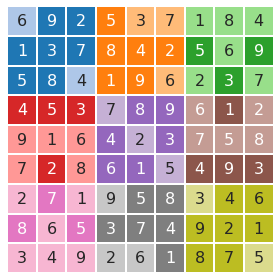

In [15]:
test = Matrix(fixed)
test.solve()

In [6]:
url='https://www.janestreet.com/puzzles/solutions/april-2019-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:10]))

The completed grid is shown to the left. The sum of the squares of the numbers written over the gray clues is 1105 . Congrats to this month’s solvers!


<img src="https://www.janestreet.com/puzzles/20190430_remote_sudoku_ans.png" width="250" >

In [7]:
filled = np.array([[6, 9, 2, 5, 3, 7, 1, 8, 4],
                  [1, 3, 7, 8, 4, 2, 5, 6, 9],
                  [5, 8, 4, 1, 9, 6, 2, 3, 7],
                  [4, 5, 3, 7, 8, 9, 6, 1, 2],
                  [9, 1, 6, 4, 2, 3, 7, 5, 8],
                  [7, 2, 8, 6, 1, 5, 4, 9, 3],
                  [2, 7, 1, 9, 5, 8, 3, 4, 6],
                  [8, 6, 5, 3, 7, 4, 9, 2, 1],
                  [3, 4, 9, 2, 6, 1, 8, 7, 5]],dtype=int)